In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,models,layers
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray
import PIL
import cv2

In [ ]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import gc

In [ ]:
import os
dataset_path = '/content/drive/MyDrive/brain tumor data set'

paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label is 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [ ]:
sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths,
                                                    labels,
                                                    stratify=labels,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1357
                                                   )

print(len(X_train), len(X_test))

202 51


In [ ]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels

        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        label = self.labels[index]

        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.augmentations(sample)

        return (sample,torch.tensor(label, dtype=torch.float))

In [ ]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

In [ ]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

torch.Size([3, 224, 224])
1.0


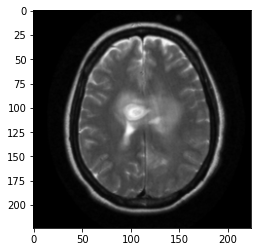

In [ ]:
import matplotlib.pyplot as plt

random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [ ]:
class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(26, 7)

In [ ]:
class Model(nn.Module):

    def __init__(self, in_features=3):
        super(Model, self).__init__()


        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                 out_channels=32,
                                                 kernel_size=3,
                                                 stride=1
                                                 ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),

                                       nn.Conv2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=3,
                                                 stride=1
                                                ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      )

        self.linear_block = nn.Sequential(nn.Linear(64*54*54, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(1024,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.3),
                                          nn.Linear(256,1)
                                         )


    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [ ]:
model = Model()
print(model)

Model(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=186624, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
class Trainer:

    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders

        self.Config = Config

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()


    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]


    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for X,y in self.train:

            X = X.to(device, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)

            self.optim.zero_grad()

            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc


    def fit(self):

        losses = []
        accuracies = []

        for epoch in range(self.Config.epochs):

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)

            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")


    @torch.no_grad()
    def inference(self):

        self.model.eval()

        running_acc = 0

        for X,y in self.test:

            X = X.to(device, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = running_acc / len(self.test)

        return accuracy

In [ ]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

EPOCH 1/10
Training Loss: 0.86711007471268 | Training Accuracy: 0.5817307692307693


EPOCH 2/10
Training Loss: 0.5791318399401811 | Training Accuracy: 0.7403846153846154


EPOCH 3/10
Training Loss: 0.49124571451774013 | Training Accuracy: 0.8076923076923077


EPOCH 4/10
Training Loss: 0.4186655959257713 | Training Accuracy: 0.8173076923076923


EPOCH 5/10
Training Loss: 0.3774581147501102 | Training Accuracy: 0.8701923076923077


EPOCH 6/10
Training Loss: 0.3364033865240904 | Training Accuracy: 0.875


EPOCH 7/10
Training Loss: 0.24468535139637354 | Training Accuracy: 0.8990384615384616


EPOCH 8/10
Training Loss: 0.19065524290244168 | Training Accuracy: 0.9423076923076923


EPOCH 9/10
Training Loss: 0.26933293868429387 | Training Accuracy: 0.8942307692307693


EPOCH 10/10
Training Loss: 0.16238184180558443 | Training Accuracy: 0.9471153846153846




In [ ]:
accuracy = trainer.inference()
accuracy*100

91.07142857142857

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

OneHotEncoder()

In [ ]:
data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/MyDrive/brain tumor data set/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
print(result)

[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1.,

In [ ]:
paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/brain tumor data set/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(139,2)
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [ ]:
y_train.shape

(111, 2)

In [ ]:
history = model.fit(x_train, y_train, epochs = 5, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/5
3/3 [==============================] - 12s 4s/step - loss: 70.7818 - val_loss: 30.7367
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 13.5431 - val_loss: 71.0112
Epoch 3/5
3/3 [==============================] - 7s 2s/step - loss: 7.0379 - val_loss: 23.1326
Epoch 4/5
3/3 [==============================] - 7s 2s/step - loss: 2.5444 - val_loss: 13.5069
Epoch 5/5
3/3 [==============================] - 7s 2s/step - loss: 3.0904 - val_loss: 12.7304


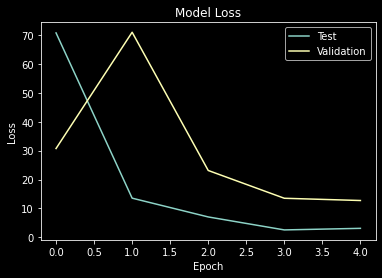

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence No, Its not a tumor


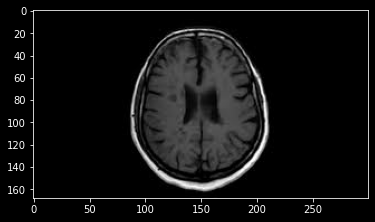

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/brain tumor data set/no/11 no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))